# 0. The problem

### Context

Our client is an Insurance company that has provided Health Insurance to its customers. Now the company needs your help to build a model capable of predict if a policyholder (customers) from past year will also be interested in **Vehicle Insurance**, also provided by the company.

A prediction model will help the company being more accurate in its communication strategy to reach out those customers most likely to purchase a vehicle insurance.

### Solution

Supposing that the company does not have enough resources to contact every client in the data base, a good strategy would be creating a list of clients ordered by their propensity of being interested in Vehicle Insurance. Such strategy would allow the company to maximize the effort of reaching the potential clients in comparison to a randomized choice in a list.

Let's say the company has a marketing budget to contact **25000** person.

The purpose is to employ a Machine Learning model to order a list of clients, from the most interested in to the less one. Next, with that list it is possible to plot a Cumulative Gains Curve to evaluate the effectiveness of the model in comparison to a randomized choice.

# 1. Data description

## 1.1. Imports

In [1]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
#sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder, StandardScaler, RobustScaler

from sklearn.feature_selection import mutual_info_classif

#from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, ConfusionMatrixDisplay

from xgboost import XGBClassifier

#from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, TargetEncoder
#from sklearn.feature_selection import mutual_info_classif
#
#from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
#
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
#from sklearn.linear_model import LogisticRegression
#
#from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, cross_validate
#from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
#
import scikitplot as skplt

In [2]:
# Random seed
seed = 42

In [3]:
# Functions
def some_metrics(y_pred, y_true):
    accuracy = accuracy_score(y_pred=y_pred, y_true=y_true)
    precision = precision_score(y_pred=y_pred, y_true=y_true)
    recall = recall_score(y_pred=y_pred, y_true=y_true)
    f1 = f1_score(y_pred=y_pred, y_true=y_true)
    print(f'Accuracy: {100*accuracy:.4f}%')
    print(f'Precision: {100*precision:.4f}%')
    print(f'Recall: {100*recall:.4f}%')
    print(f'F1 score: {f1:.4f}')

## 1.2. Loading data

Data available at https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction

In [4]:
PATH = '../data/raw/train.csv'

df_raw = pd.read_csv(filepath_or_buffer=PATH)
df = df_raw.copy()

# 2. Exploratory Data Analysis (EDA)

## 2.1. Data description

In [5]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Columns description:

* **id**                      Unique ID for the customer  
* **Gender**                  Gender of the customer  
* **Age**                     Age of the customer  
* **Driving_License**         0 : Customer does not have DL, 1 : Customer already has DL  
* **Region_Code** 	        Unique code for the region of the customer  
* **Previously_Insured**	    1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance  
* **Vehicle_Age** 	        Age of the Vehicle  
* **Vehicle_Damage** 	        1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.  
* **Annual_Premium** 	        The amount customer needs to pay as premium in the year  
* **Policy_Sales_Channel** 	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.  
* **Vintage** 	            Number of Days which customer has been associated with the company  
* **Response** 	            1 : Customer is interested, 0 : Customer is not interested

* Currency: Idian Rupee (Rs)

In [6]:
#df_train.columns = df_train.columns.str.lower()

#### Shape

In [7]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 381109
Number of columns: 12


In [8]:
## id column has no importance and can be removed
#df_train.drop(columns=['id'], inplace=True)

#### Types

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


**Summary**
- Categorical variables:
    - gender (object)
    - driving license (int64)
    - previously insured (int64)
    - region code (float64)
    - policy sales channel (float64)
    - vehicle age (object)
    - vehicle damage (object)
    - response (int64)
- Variable representing numerical variables:
    - age
    - annual premium
    - vintage

#### Transform type of some categorical features

In [10]:
#df['Driving_License'] = df['Driving_License'].astype('category')
#df['Previously_Insured'] = df['Previously_Insured'].astype('category')
#df['Region_Code'] = df['Region_Code'].astype('category')
#df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('category')

#### Missing values
-> No missing values

In [11]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

#### Duplicated
-> The number of duplicates is low, so they were removed with no further investigation

In [12]:
df.duplicated().sum()

0

In [13]:
#df_train.drop_duplicates(inplace=True)

#### Split data into train and test

In [14]:
df_train, df_valid = train_test_split(df, train_size=0.7, stratify=df['Response'], random_state=seed)

#### Target variable
-> Unbalanced target

<Axes: xlabel='Response', ylabel='count'>

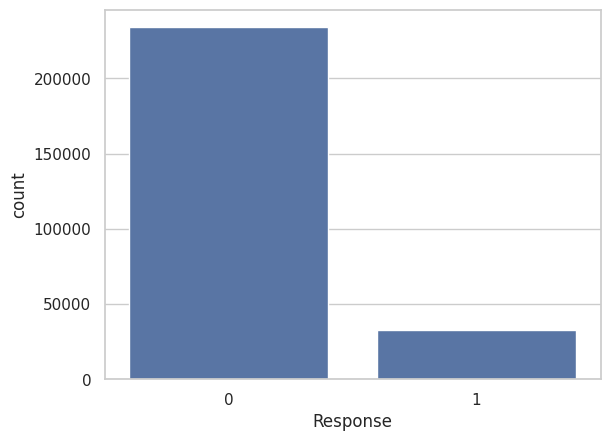

In [15]:
sns.countplot(data=df_train, x=df_train['Response'])

In [16]:
print(f'Total of interested: {df_train["Response"].value_counts(normalize=True)[1]*100:.2f}%')
print(f'Total of not interested: {df_train["Response"].value_counts(normalize=True)[0]*100:.2f}%')

Total of interested: 12.26%
Total of not interested: 87.74%


#### Numerical variables

In [17]:
num_columns = df_train[["Age", "Annual_Premium", "Vintage"]].columns.tolist()
#num_columns = df_train.select_dtypes(exclude=['object', 'category']).columns.tolist()
#num_columns.pop(0)
num_columns

['Age', 'Annual_Premium', 'Vintage']

In [18]:
df_train[num_columns].describe()

,Age,Annual_Premium,Vintage
count,266776.000000,266776.000000,266776.000000
mean,38.843389,30597.529234,154.423246
std,15.513232,17234.538416,83.652733
min,20.000000,2630.000000,10.000000
25%,25.000000,24406.000000,82.000000
50%,36.000000,31693.000000,154.000000
75%,49.000000,39448.000000,227.000000
max,85.000000,540165.000000,299.000000


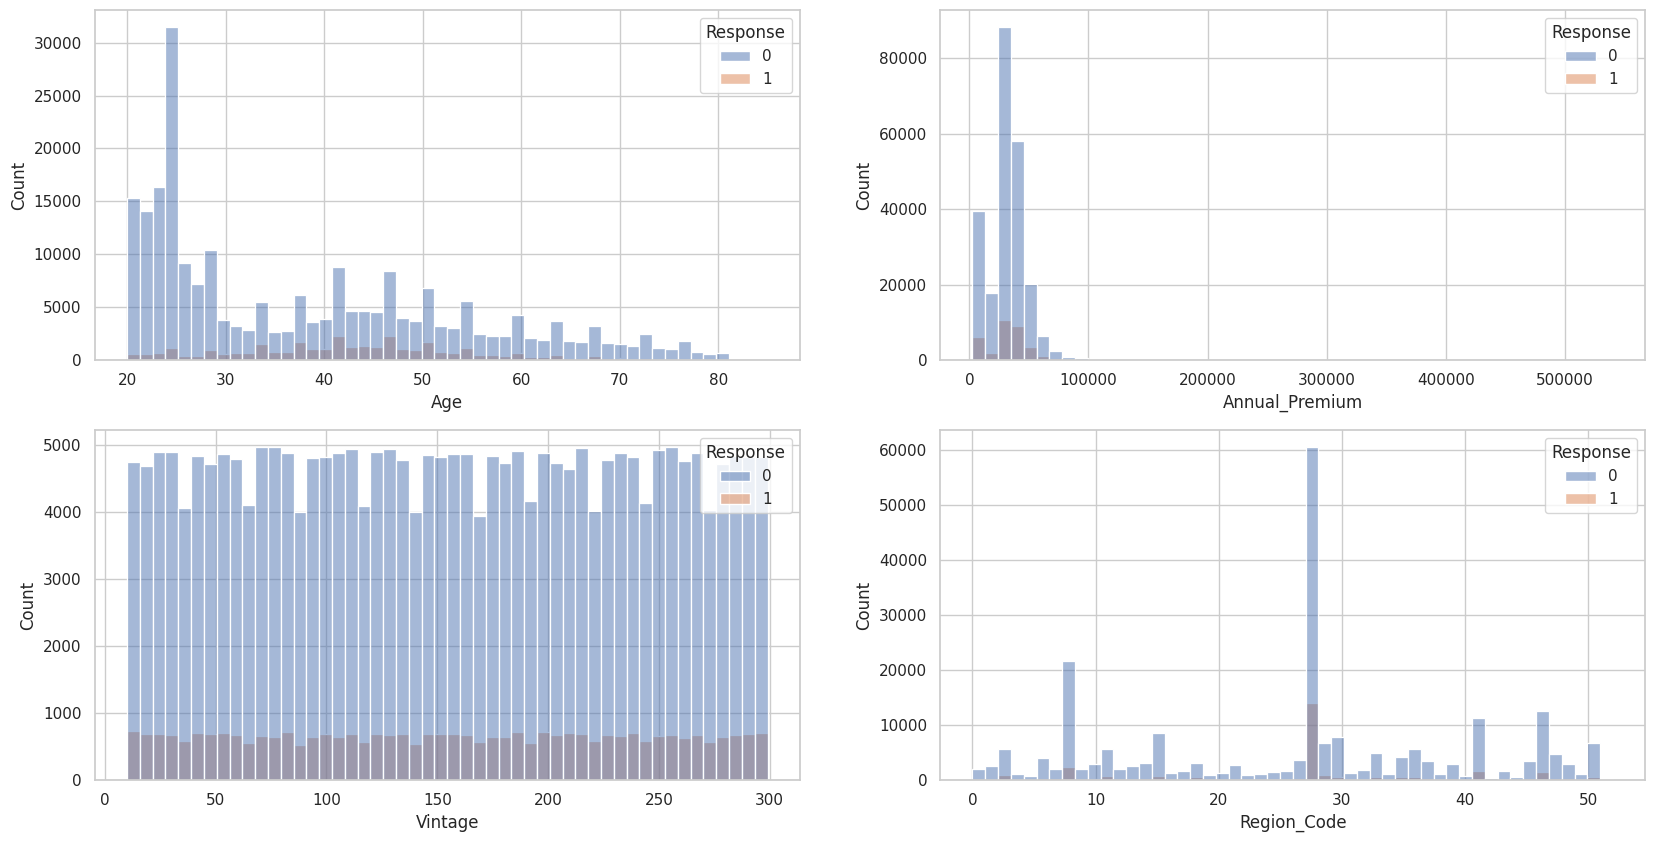

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
sns.histplot(data=df_train, x='Age', hue='Response', bins=50, ax=ax[0][0])
sns.histplot(data=df_train, x='Annual_Premium', bins=50, hue='Response', ax=ax[0][1])
sns.histplot(data=df_train, x='Vintage', hue='Response', bins=50, ax=ax[1][0])
sns.histplot(data=df_train, x='Region_Code', hue='Response', bins=50, ax=ax[1][1]);

#### Categorical variables

In [20]:
#cat_columns = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
cat_columns = df_train.drop(columns=num_columns).columns.tolist()
cat_columns.pop(0)
cat_columns

['Gender',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Policy_Sales_Channel',
 'Response']

<Axes: xlabel='Driving_License', ylabel='count'>

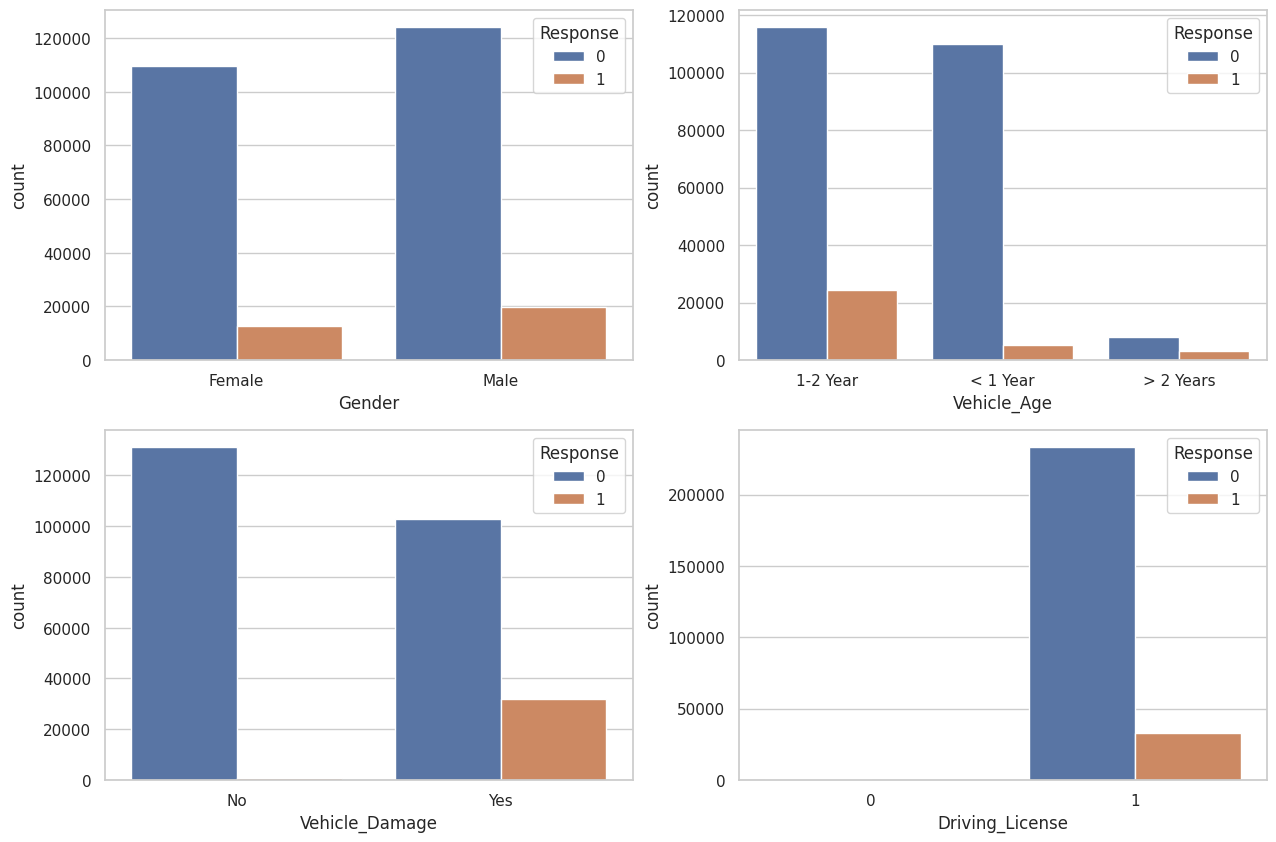

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
sns.countplot(data=df_train, x='Gender', hue='Response', ax=ax[0][0])
sns.countplot(data=df_train, x='Vehicle_Age', hue='Response', ax=ax[0][1])
sns.countplot(data=df_train, x='Vehicle_Damage', hue='Response', ax=ax[1][0])
sns.countplot(data=df_train, x='Driving_License', hue='Response', ax=ax[1][1])

## 2.2. Hypothesis

#### **H1**: Individuals between 30 and 50 years old would be more likely to purchase a vehicle insurance.
-> True

In [22]:
between_30_50 = df_train.query('Age >= 30 & Age <= 50 & Response == 1').shape[0]
below_30 = df_train.query('Age < 30 and Response == 1').shape[0]
over_50 = df_train.query('Age > 50 and Response == 1').shape[0]

In [23]:
aux1 = pd.DataFrame({'below_30': [below_30],
                     'between_30_50': [between_30_50],
                     'over_50': [over_50]})
aux1

,below_30,between_30_50,over_50
0,4478,19919,8300


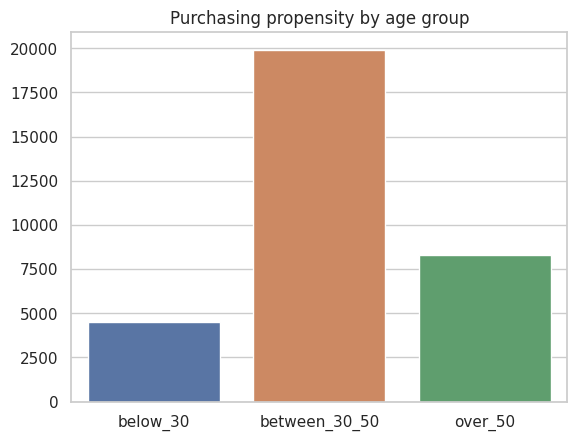

In [24]:
sns.barplot(data=aux1)
plt.title('Purchasing propensity by age group');

#### **H2**: Women would be more interested in having vehicle insurance.
-> False. 10,4% of total women would purchase compared to 13,8% of total men.

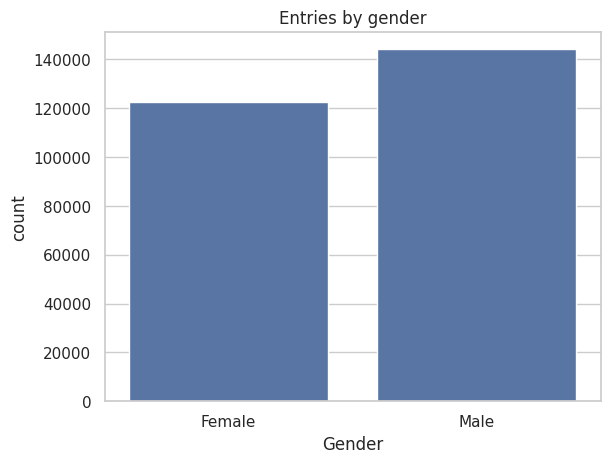

In [25]:
sns.countplot(data=df_train, x='Gender')
plt.title('Entries by gender');

In [26]:
# Result given in proportion by gender
gender_count = pd.crosstab(df_train['Response'], df_train['Gender'], normalize='columns')
gender_count

Gender,Female,Male
Response,,
0,0.895467,0.862104
1,0.104533,0.137896


Text(0.5, 1.0, 'Interest by gender')

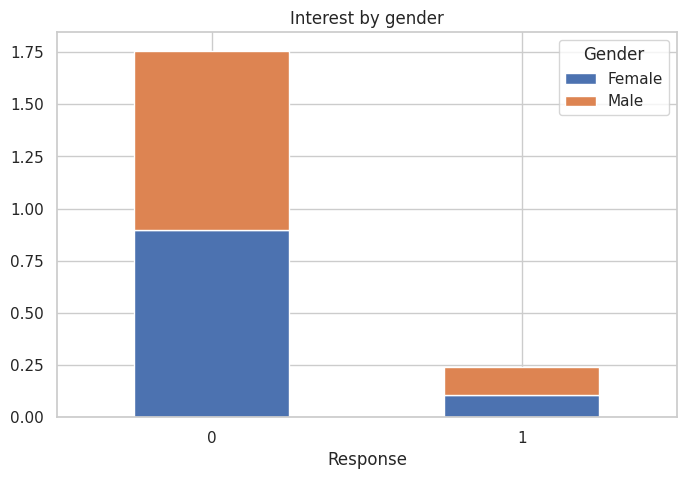

In [27]:
fig, ax = plt.subplots(figsize=(8,5))
gender_count.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=0)
plt.title('Interest by gender')

#### **H3**: Individuals who already have driver license and got the vehicle damage in the past would be more interested in vehicle insurance.
-> False.

In [28]:
aux3 = df_train.query('Driving_License == 1 & Vehicle_Damage == "Yes"')['Response'].value_counts()

Text(0.5, 1.0, 'Purchasing propensity among people who Driving_License = 1 and Vehicle_Damage = Yes')

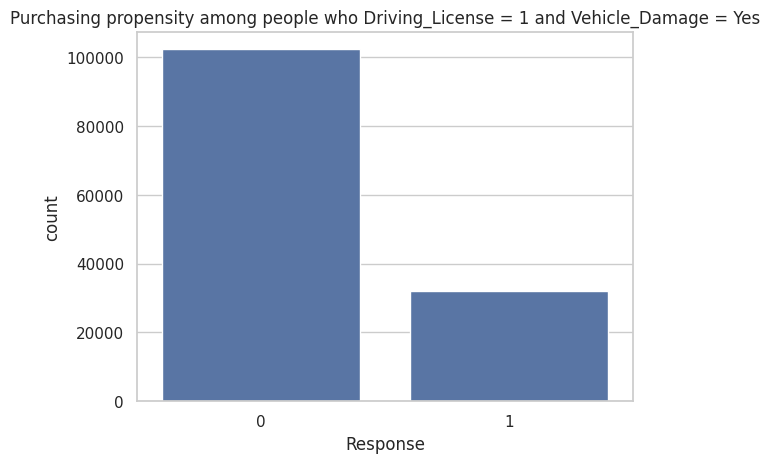

In [29]:
sns.barplot(data=aux3)
plt.title('Purchasing propensity among people who Driving_License = 1 and Vehicle_Damage = Yes')

#### **H4**: Individuals who already have vehicle insurance (previously insured) would not be interested in vehicle insurance.
-> True. 99,91% of those who already have insurance would not purchase another one

In [30]:
pd.crosstab(index=df_train['Response'], columns=df_train['Previously_Insured'], normalize='columns')

Previously_Insured,0,1
Response,,
0,0.774536,0.9991
1,0.225464,0.0009


#### **H5**: Individuals who got the vehicle damaged and were not previously insured would be more interested in vehicle insurance.
-> False. Even if not being insured, people who have vehicle damaged would not purschase

<Axes: xlabel='Response', ylabel='count'>

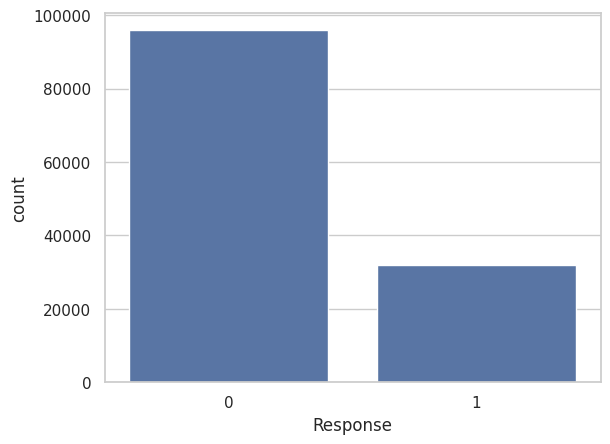

In [31]:
aux5 = df_train.query('Vehicle_Damage == "Yes" & Previously_Insured == 0')['Response'].value_counts()
sns.barplot(data=aux5)

#### **H6**: Individuals who own vehicle with more than two year would be more interested in vehicle insurance.
-> FALSE. Ownners of vehicles between 1-2 years are the most interested.

In [32]:
aux7 = pd.crosstab(index=df['Response'], columns=df['Vehicle_Age'])
aux7

Vehicle_Age,1-2 Year,< 1 Year,> 2 Years
Response,,,
0,165510,157584,11305
1,34806,7202,4702


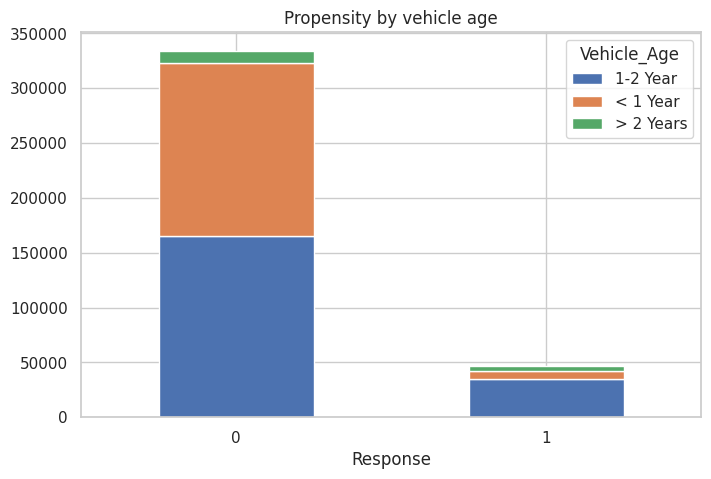

In [33]:
fig, ax = plt.subplots(figsize=(8,5))
aux7.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=0)
plt.title('Propensity by vehicle age');

<Axes: xlabel='Vehicle_Damage', ylabel='count'>

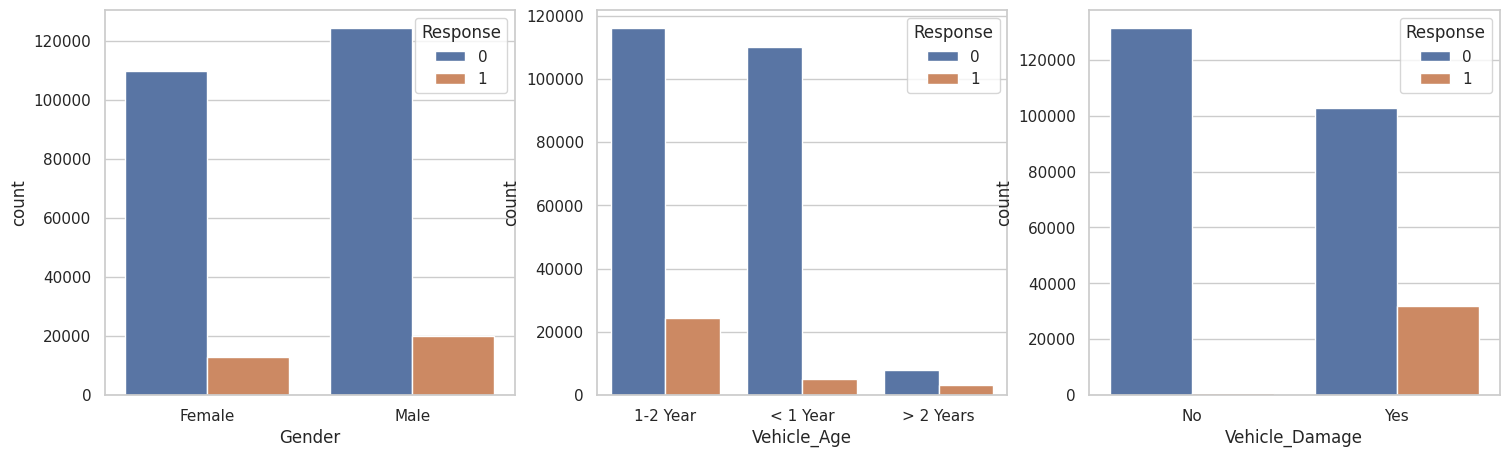

In [34]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
sns.countplot(data=df_train, x=df_train['Gender'], hue=df_train['Response'], ax=ax[0])
sns.countplot(data=df_train, x=df_train['Vehicle_Age'], hue=df_train['Response'], ax=ax[1])
sns.countplot(data=df_train, x=df_train['Vehicle_Damage'], hue=df_train['Response'], ax=ax[2])

#### Vehicle Damage = No --> almost everybody is not interested 

#### Policy sales channel

In [35]:
aux = df_train.groupby('Policy_Sales_Channel')['Response'].sum().reset_index()
aux

,Policy_Sales_Channel,Response
0,1.0,19
1,2.0,1
2,3.0,110
3,4.0,76
4,6.0,0
...,...,...
148,157.0,1274
149,158.0,93
150,159.0,1
151,160.0,325


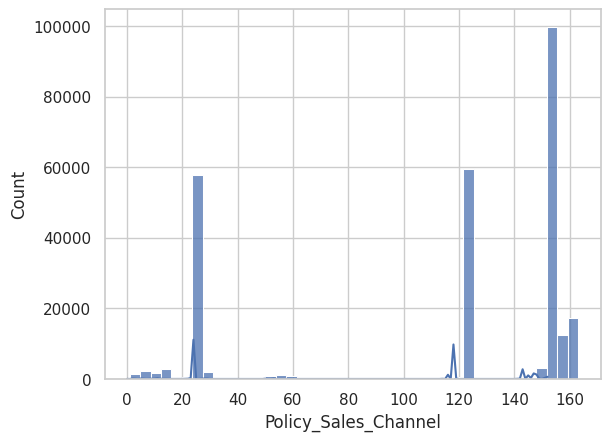

In [36]:
plt.figure()
ax = sns.histplot(data=df_train, x='Policy_Sales_Channel')
ax = plt.plot(aux['Response'])

# 3. Feature Engineering

In [37]:
df_train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
223531,223532,Female,46,1,23.0,1,1-2 Year,No,34564.0,26.0,71,0
337977,337978,Male,51,1,28.0,1,1-2 Year,No,31982.0,26.0,76,0
320307,320308,Female,40,1,33.0,0,1-2 Year,No,2630.0,12.0,276,0
261303,261304,Female,28,1,4.0,1,< 1 Year,No,2630.0,152.0,223,0
71160,71161,Female,21,1,37.0,1,< 1 Year,No,30939.0,160.0,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...
149107,149108,Male,21,1,15.0,0,< 1 Year,Yes,48284.0,160.0,70,0
378816,378817,Male,25,1,47.0,1,< 1 Year,Yes,23010.0,160.0,58,0
91744,91745,Male,24,1,28.0,0,< 1 Year,No,59094.0,152.0,62,0
48700,48701,Female,40,1,8.0,1,1-2 Year,No,28940.0,26.0,262,0


## 3.1. Data preparation

In [38]:
# Transform vehicle_damage to binary
df_train['Vehicle_Damage'] = df_train['Vehicle_Damage'].apply(lambda x: 0 if x=='No' else 1)

In [39]:
# Mapping gender --> Male:0, Female:1
gender_map = {"Male": 0, "Female": 1}
df_train["Gender"] = df_train["Gender"].map(gender_map)

In [40]:
# Rewrite vehicle age
#age_dict = {'1-2 Year': 'between_1_2',
#            '< 1 Year': 'below_1',
#            '> 2 Years': 'over_2'}

age_dict = {'< 1 Year': 1,
            '1-2 Year': 2,
            '> 2 Years': 3}

df_train['Vehicle_Age'] = df_train['Vehicle_Age'].map(age_dict)

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266776 entries, 223531 to 221791
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    266776 non-null  int64  
 1   Gender                266776 non-null  int64  
 2   Age                   266776 non-null  int64  
 3   Driving_License       266776 non-null  int64  
 4   Region_Code           266776 non-null  float64
 5   Previously_Insured    266776 non-null  int64  
 6   Vehicle_Age           266776 non-null  int64  
 7   Vehicle_Damage        266776 non-null  int64  
 8   Annual_Premium        266776 non-null  float64
 9   Policy_Sales_Channel  266776 non-null  float64
 10  Vintage               266776 non-null  int64  
 11  Response              266776 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 26.5 MB


In [42]:
# Transform type of some categorical features
df_train["Gender"] = df_train["Gender"].astype("category")
df_train['Driving_License'] = df_train['Driving_License'].astype('category')
df_train['Previously_Insured'] = df_train['Previously_Insured'].astype('category')
df_train["Vehicle_Damage"] = df_train["Vehicle_Damage"].astype("category")
df_train['Region_Code'] = df_train['Region_Code'].astype('category')
df_train['Policy_Sales_Channel'] = df_train['Policy_Sales_Channel'].astype('category')
df_train["Response"] = df_train["Response"].astype("category")

In [43]:
X_train = df_train.drop(columns="Response").copy()

y_train = df_train['Response']

print(f'Training dataframe shape: {df_train.shape}')

Training dataframe shape: (266776, 12)


In [44]:
X_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
223531,223532,1,46,1,23.0,1,2,0,34564.0,26.0,71
337977,337978,0,51,1,28.0,1,2,0,31982.0,26.0,76
320307,320308,1,40,1,33.0,0,2,0,2630.0,12.0,276
261303,261304,1,28,1,4.0,1,1,0,2630.0,152.0,223
71160,71161,1,21,1,37.0,1,1,0,30939.0,160.0,38


In [45]:
# Make column names lowercase
X_train.columns = X_train.columns.str.lower()

y_train.name = y_train.name.lower()

In [46]:
num_columns = X_train.select_dtypes(exclude=['object', 'category']).columns.to_list()
cat_columns = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

In [47]:
num_columns

['id', 'age', 'vehicle_age', 'annual_premium', 'vintage']

In [48]:
cat_columns

['gender',
 'driving_license',
 'region_code',
 'previously_insured',
 'vehicle_damage',
 'policy_sales_channel']

In [49]:
X_train.nunique()

id                      266776
gender                       2
age                         66
driving_license              2
region_code                 53
previously_insured           2
vehicle_age                  3
vehicle_damage               2
annual_premium           44991
policy_sales_channel       153
vintage                    290
dtype: int64

In [50]:
#df_train.dropna(inplace=True)
#df_train.drop_duplicates(inplace=True)

## 3.3. Encoding

### 3.3.1. One hot encode

In [51]:
## General function for One Hot Encoder
#def one_hot_encoder(df_to_encode, feature_to_encode):
#    encoder = OneHotEncoder(drop='if_binary')
#    new_features = encoder.fit_transform(df_to_encode[feature_to_encode]).toarray()
#    df_to_encode[encoder.get_feature_names_out()] = new_features
#    df_to_encode.drop(columns=encoder.feature_names_in_[0], inplace=True)
#    return df_to_encode, encoder

In [52]:
# Gender ---> OBS: Test dummy encoding
#X_train, encoding_gender = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['gender'])

In [53]:
# Driving license
#X_train, encoding_license = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['driving_license'])

In [54]:
# Previously insured
#X_train, encoding_insured = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['previously_insured'])

In [55]:
# Vehicle damage
#X_train, encoding_damage = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['vehicle_damage'])

In [56]:
# Vehicle age
# OBS: Testar Ordinal Enconding ou Target Enconding
#X_train, encoding_v_age = one_hot_encoder(df_to_encode=X_train, feature_to_encode=['vehicle_age'])

### 3.3.2. Target encode

In [57]:
# Region code
tar_enc_reg_code = TargetEncoder()
X_train['region_code'] = tar_enc_reg_code.fit_transform(X=X_train[['region_code']], y=y_train)

In [58]:
# Policy sales channel
tar_enc_pol_sales = TargetEncoder()
X_train['policy_sales_channel'] = tar_enc_pol_sales.fit_transform(X=X_train[['policy_sales_channel']], y=y_train)

In [59]:
X_train

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
223531,223532,1,46,1,0.153177,1,2,0,34564.0,0.199578,71
337977,337978,0,51,1,0.186378,1,2,0,31982.0,0.198735,76
320307,320308,1,40,1,0.094362,0,2,0,2630.0,0.170644,276
261303,261304,1,28,1,0.155030,1,1,0,2630.0,0.029589,223
71160,71161,1,21,1,0.079354,1,1,0,30939.0,0.021737,38
...,...,...,...,...,...,...,...,...,...,...,...
149107,149108,0,21,1,0.075179,0,1,1,48284.0,0.021737,70
378816,378817,0,25,1,0.083870,1,1,1,23010.0,0.021545,58
91744,91745,0,24,1,0.186378,0,1,0,59094.0,0.028724,62
48700,48701,1,40,1,0.095574,1,2,0,28940.0,0.199578,262


## 3.4. Rescaling

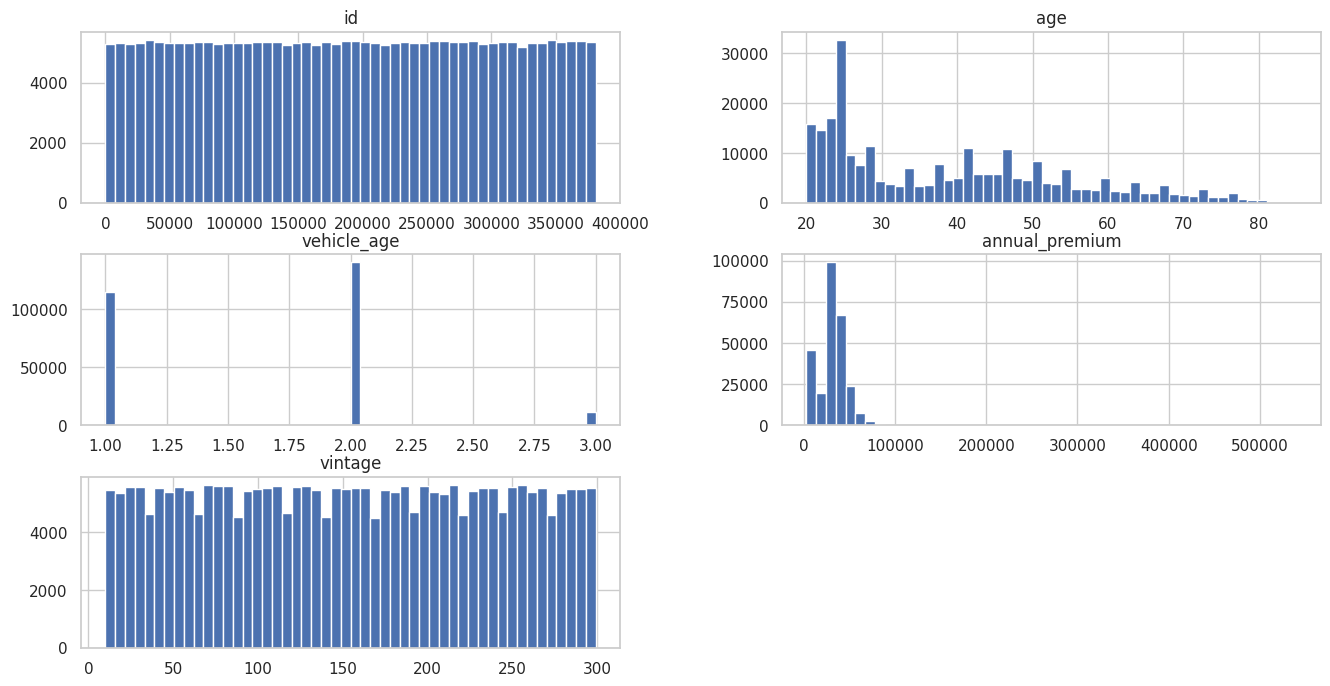

In [60]:
X_train[num_columns].hist(bins=50, figsize=(16,8));

### Vintage - MinMax scaler,Standard scaler, Quantile transform

In [61]:
#std_vintage = MinMaxScaler()
std_vintage = StandardScaler()
#std_vintage = QuantileTransformer()
#std_vintage = PowerTransformer(method='box-cox')
#std_vintage = RobustScaler()

new_vintage = std_vintage.fit_transform(X_train[['vintage']])
X_train['vintage'] = new_vintage

### Age - MinMax scaler, Standard scaler, Box-Cox or Quantile transform

In [62]:
#std_age = MinMaxScaler()
std_age = StandardScaler()
#std_age = QuantileTransformer()
#std_age = PowerTransformer(method='box-cox')
#std_age = RobustScaler()

#aux1 = X_train[['age']].transform(np.log1p)
#new_age = std_age.fit_transform(aux1)
new_age = std_age.fit_transform(X_train[['age']])
X_train['age'] = new_age

### Anual premium - Standard scaler, Robust scaler, Box-Cox or Quantile transform

Text(0.5, 1.0, 'Some scalling')

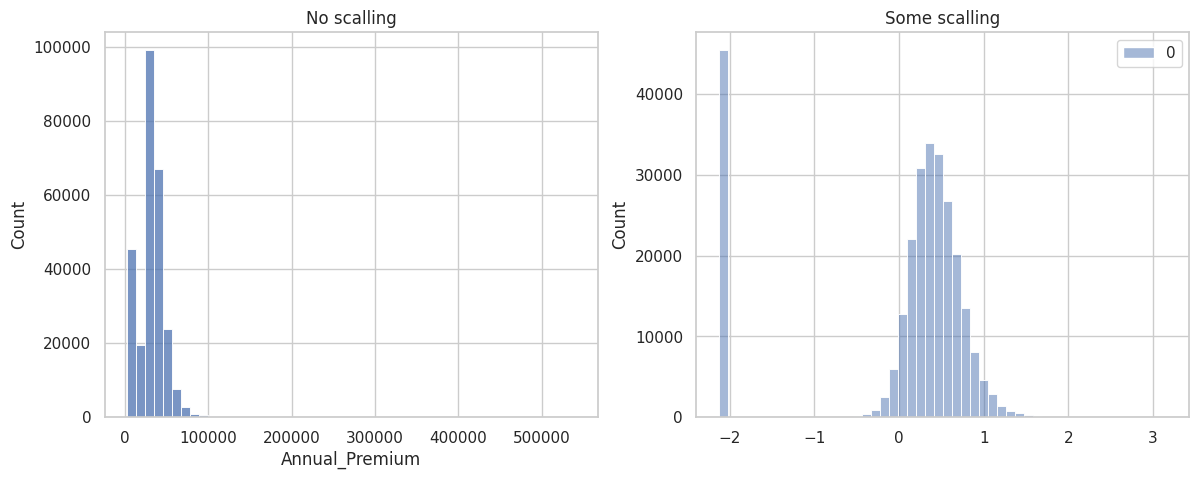

In [63]:
#std_vintage = MinMaxScaler()
std_anual_pr = StandardScaler()
#std_anual_pr = QuantileTransformer()
#std_anual_pr = PowerTransformer(method='box-cox')
#std_anual_pr = RobustScaler()

aux1 = X_train[['annual_premium']].transform(np.log1p)
new_anual_pr = std_anual_pr.fit_transform(aux1)
#new_anual_pr = std_anual_pr.fit_transform(X_train[['annual_premium']])
X_train['annual_premium'] = new_anual_pr

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.histplot(data=df_train['Annual_Premium'], bins=50, ax=ax[0])
sns.histplot(data=new_anual_pr, bins=50, ax=ax[1])
ax[0].set_title('No scalling')
ax[1].set_title('Some scalling')

## 3.5. Validation dataframe

In [64]:
# Transform vehicle_damage to binary
df_valid['Vehicle_Damage'] = df_valid['Vehicle_Damage'].apply(lambda x: 0 if x=='No' else 1)

# Mapping gender --> Male:0, Female:1
gender_map = {"Male": 0, "Female": 1}
df_valid["Gender"] = df_valid["Gender"].map(gender_map)

# Rewrite vehicle age
age_dict = {'< 1 Year': 1,
            '1-2 Year': 2,
            '> 2 Years': 3}
df_valid['Vehicle_Age'] = df_valid['Vehicle_Age'].map(age_dict)

# Transform type of some categorical features
df_valid["Gender"] = df_valid["Gender"].astype("category")
df_valid['Driving_License'] = df_valid['Driving_License'].astype('category')
df_valid['Previously_Insured'] = df_valid['Previously_Insured'].astype('category')
df_valid["Vehicle_Damage"] = df_valid["Vehicle_Damage"].astype("category")
df_valid['Region_Code'] = df_valid['Region_Code'].astype('category')
df_valid['Policy_Sales_Channel'] = df_valid['Policy_Sales_Channel'].astype('category')
df_valid["Response"] = df_valid["Response"].astype("category")

# id column has no importance and can be removed
#df_valid.drop(columns=['id'], inplace=True)
X_valid = df_valid.drop(columns="Response").copy()
y_valid = df_valid['Response']

# Make column names lowercase
X_valid.columns = X_valid.columns.str.lower()
y_valid.name = y_valid.name.lower()

In [65]:
#X_valid[encoding_gender.get_feature_names_out()] =encoding_gender.transform(X=X_valid[['gender']]).toarray()
#X_valid.drop(columns=encoding_gender.feature_names_in_[0], inplace=True)
#
#X_valid[encoding_license.get_feature_names_out()] =encoding_license.transform(X=X_valid[['driving_license']]).toarray()
#X_valid.drop(columns=encoding_license.feature_names_in_[0], inplace=True)
#
#X_valid[encoding_insured.get_feature_names_out()] =encoding_insured.transform(X=X_valid[['previously_insured']]).toarray()
#X_valid.drop(columns=encoding_insured.feature_names_in_[0], inplace=True)
#
#X_valid[encoding_damage.get_feature_names_out()] =encoding_damage.transform(X=X_valid[['vehicle_damage']]).toarray()
#X_valid.drop(columns=encoding_damage.feature_names_in_[0], inplace=True)
#
#X_valid[encoding_v_age.get_feature_names_out()] =encoding_v_age.transform(X=X_valid[['vehicle_age']]).toarray()
#X_valid.drop(columns=encoding_v_age.feature_names_in_[0], inplace=True)

In [66]:
X_valid['region_code'] = tar_enc_reg_code.transform(X=X_valid[['region_code']])

X_valid['policy_sales_channel'] = tar_enc_pol_sales.transform(X=X_valid[['policy_sales_channel']])

In [67]:
X_valid['age'] = std_age.transform(X=X_valid[['age']])

X_valid['vintage'] = std_vintage.transform(X=X_valid[['vintage']])

X_valid['annual_premium'] = std_anual_pr.transform(X=X_valid[['annual_premium']].transform(np.log1p))

In [68]:
X_train_no_id = X_train.drop(columns=["id"])
X_valid_no_id = X_valid.drop(columns=["id"])

## 3.6. Feature selection

### 3.6.1. Correlation matrix

In [69]:
aux = X_train.drop(columns=["id"])
aux = aux.join(y_train)

<Axes: >

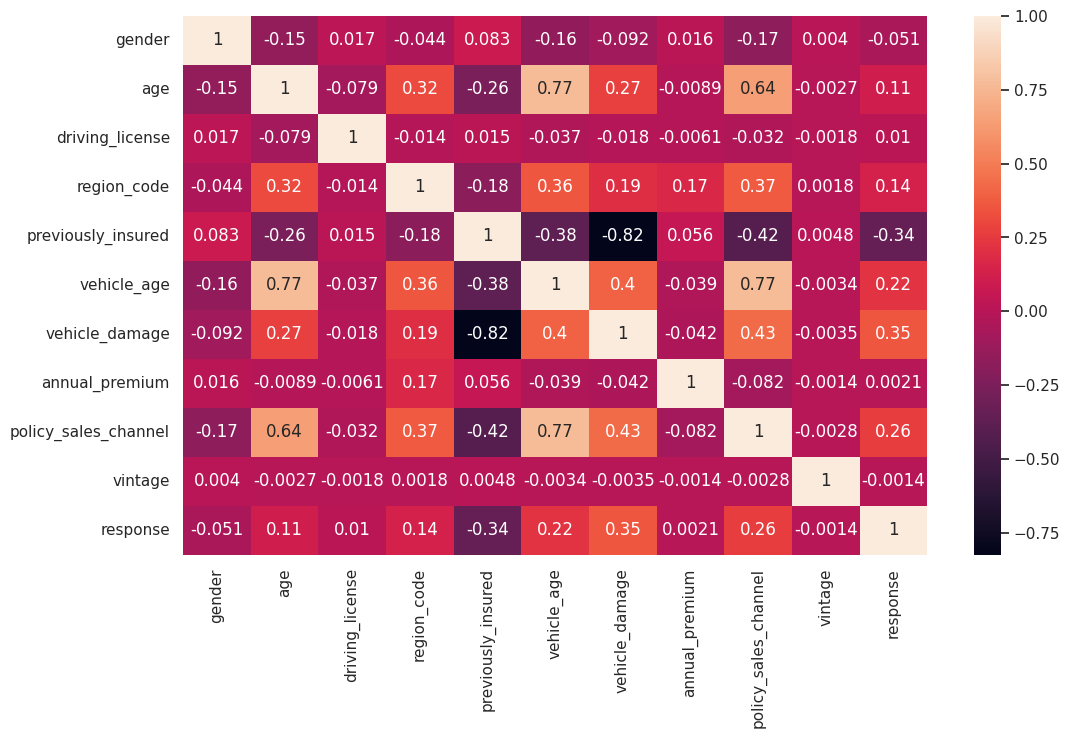

In [70]:
corr_matrix = aux.corr()
plt.figure(figsize=(12,7))
sns.heatmap(data=corr_matrix, annot=True)

In [71]:
corr_matrix["response"].sort_values(ascending=False)

response                1.000000
vehicle_damage          0.353954
policy_sales_channel    0.260139
vehicle_age             0.220229
region_code             0.135492
age                     0.110583
driving_license         0.009976
annual_premium          0.002096
vintage                -0.001368
gender                 -0.050701
previously_insured     -0.341194
Name: response, dtype: float64

### 3.6.1. Tree-based

In [72]:
feat_imp_clf = RandomForestClassifier(n_estimators=400, random_state=seed, n_jobs=-1)
feat_imp_clf.fit(X=X_train_no_id, y=y_train)

tree_based_score = pd.DataFrame(data=feat_imp_clf.feature_importances_, index=X_train_no_id.columns,
                                columns=['tree_based']).sort_values(by='tree_based', ascending=False)

In [73]:
tree_based_score

,tree_based
vintage,0.218621
annual_premium,0.195298
region_code,0.153179
policy_sales_channel,0.144029
age,0.135596
vehicle_damage,0.069483
previously_insured,0.052721
vehicle_age,0.016411
gender,0.014131
driving_license,0.000530


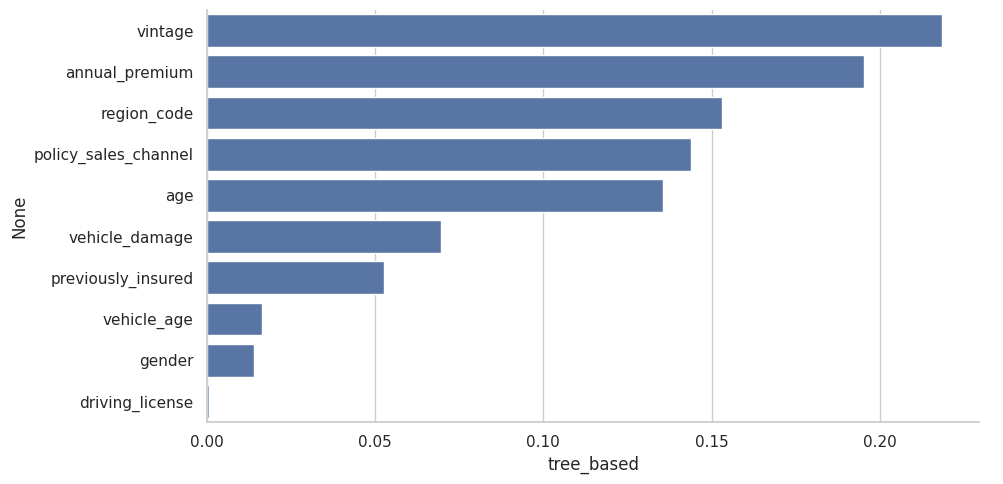

In [74]:
sns.catplot(data=tree_based_score, y=tree_based_score.index, x='tree_based', kind='bar', aspect=2)

### 3.6.1. Mutual information

In [75]:
mi_score = mutual_info_classif(X=X_train_no_id, y=y_train, random_state=seed, n_jobs=-1)
mi_score = pd.DataFrame(data=mi_score, index=X_train_no_id.columns, columns=['mi_score']).sort_values(by='mi_score', ascending=False)

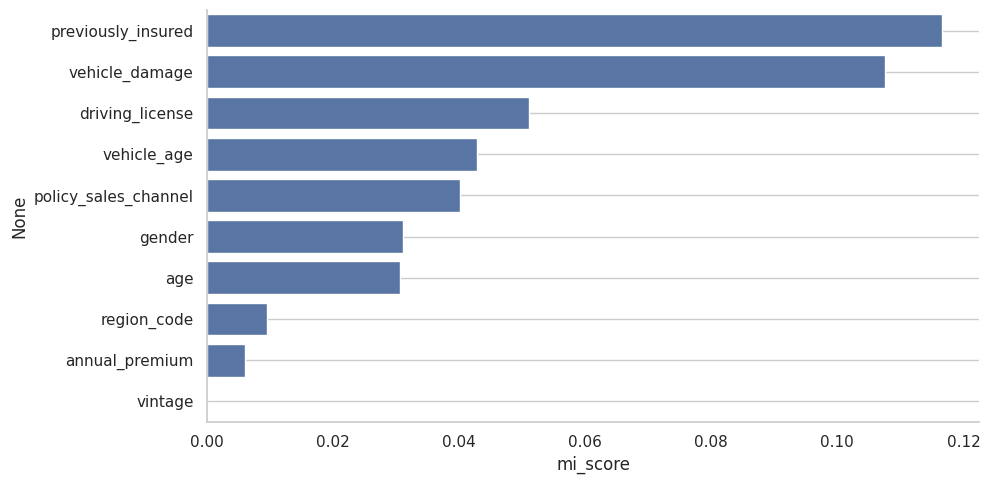

In [76]:
sns.catplot(data=mi_score, y=mi_score.index, x='mi_score', kind='bar', aspect=2)
plt.grid()

# 4. Machine Learning Modeling

**Metrics**:
- Caution with accuracy because the target classes are unbalanced. There is much more people who are not interested in car insurence
- It is important to indentify as many customers as possible who are interested in car insurance, even though the model makes some mistakes ==> Recall

## 4.1. Using all features

In [77]:
features = X_train_no_id.columns.to_list()
features

['gender',
 'age',
 'driving_license',
 'region_code',
 'previously_insured',
 'vehicle_age',
 'vehicle_damage',
 'annual_premium',
 'policy_sales_channel',
 'vintage']

### 4.1.1. Training models

#### Select k-best features

#### Logistic Regression

In [78]:
log_reg_clf = LogisticRegression(class_weight='balanced', random_state=seed)
log_reg_clf.fit(X=X_train[features], y=y_train)
y_pred_log_reg = log_reg_clf.predict(X=X_valid[features])
y_pred_proba_log_reg = log_reg_clf.predict_proba(X=X_valid[features])
roc_log_reg = roc_auc_score(y_score=y_pred_proba_log_reg[:,1], y_true=y_valid)

#### Random Forest

In [79]:
rf_clf = RandomForestClassifier(n_estimators=500,
                                criterion="entropy",
                                max_depth=8,
                                class_weight="balanced",
                                n_jobs=-1,
                                random_state=seed)
rf_clf.fit(X=X_train[features], y=y_train)
y_pred_rf = rf_clf.predict(X=X_valid[features])
y_pred_proba_rf = rf_clf.predict_proba(X=X_valid[features])
roc_rf = roc_auc_score(y_score=y_pred_proba_rf[:,1], y_true=y_valid)

#### HGBoosting

In [115]:
hgb_clf = HistGradientBoostingClassifier(learning_rate=0.05,
                                         l2_regularization=0.1,
                                         max_features=0.8,
                                         class_weight="balanced",
                                         categorical_features="from_dtype",
                                         random_state=seed)
hgb_clf.fit(X=X_train[features], y=y_train)
y_pred_hgb = hgb_clf.predict(X=X_valid[features])
y_pred_proba_hgb = hgb_clf.predict_proba(X=X_valid[features])
roc_hgb = roc_auc_score(y_score=y_pred_proba_hgb[:,1], y_true=y_valid)

#### XGBoosting

In [80]:
xgb_clf = XGBClassifier(n_estimators=2000,
                        learning_rate=0.5,
                        max_depth=0,
                        subsample=0.25,
                        colsample_bytree=0.5,
                        objective="binary:logistic",
                        enable_categorical=True,
                        random_state=seed)
xgb_clf.fit(X=X_train[features], y=y_train)
y_pred_xgb = xgb_clf.predict(X=X_valid[features])
y_pred_proba_xgb = xgb_clf.predict_proba(X=X_valid[features])
roc_xgb = roc_auc_score(y_score=y_pred_proba_xgb[:,1], y_true=y_valid)

In [157]:
#hgb_clf = HistGradientBoostingClassifier(random_state=42)
#hgb_clf.fit(X=X_train[features], y=y_train)
#y_pred_hgb = hgb_clf.predict(X=X_valid[features])
#y_pred_proba_hgb = hgb_clf.predict_proba(X=X_valid[features])
#roc_hgb = roc_auc_score(y_score=y_pred_proba_hgb[:,1], y_true=y_valid)

## 4.2. Results

In [81]:
def metrics(models):

    results = {'Model': [],
               'Accuracy': [],
               'Precision': [],
               'Recall': [],
               'ROC_AUC': []}

    for name, pred in models.items():
        results['Model'].append(name)
        results['Accuracy'].append(accuracy_score(y_pred=pred[0], y_true=y_valid))
        results['Precision'].append(precision_score(y_pred=pred[0], y_true=y_valid))
        results['Recall'].append(recall_score(y_pred=pred[0], y_true=y_valid))
        results["ROC_AUC"].append(pred[1])

    results = pd.DataFrame(results).set_index('Model')
    results.index.names = [None]
    return pd.DataFrame(results)

In [116]:
models = {'Logistic Regression': [y_pred_log_reg, roc_log_reg],
          'Random Forest': [y_pred_rf, roc_rf],
          "HGBoost": [y_pred_hgb, roc_hgb],
          'XGBoost': [y_pred_xgb, roc_xgb]}

results = metrics(models)
results.style.highlight_max(color='green', axis=0)

,Accuracy,Precision,Recall,ROC_AUC
Logistic Regression,0.679087,0.269073,0.942839,0.846699
Random Forest,0.697987,0.280618,0.936416,0.855855
HGBoost,0.703209,0.283384,0.929851,0.858768
XGBoost,0.833110,0.302771,0.277599,0.794521


#### Confusion matrix

In [117]:
def plot_confusion_matrix(models_list, y_true):
    fig, ax = plt.subplots(1,len(models_list), figsize=(5*len(models_list), 5))
    fig.suptitle('Confusion Matrix')
    n_ax = 0
    for name, pred in models_list.items():
       n_ax = n_ax + 1
       ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=pred[0], ax=ax[n_ax-1], cmap='Blues',colorbar=False)
       ax[n_ax-1].set_title(name)
    for axes in ax.flatten():
        axes.grid(False)    

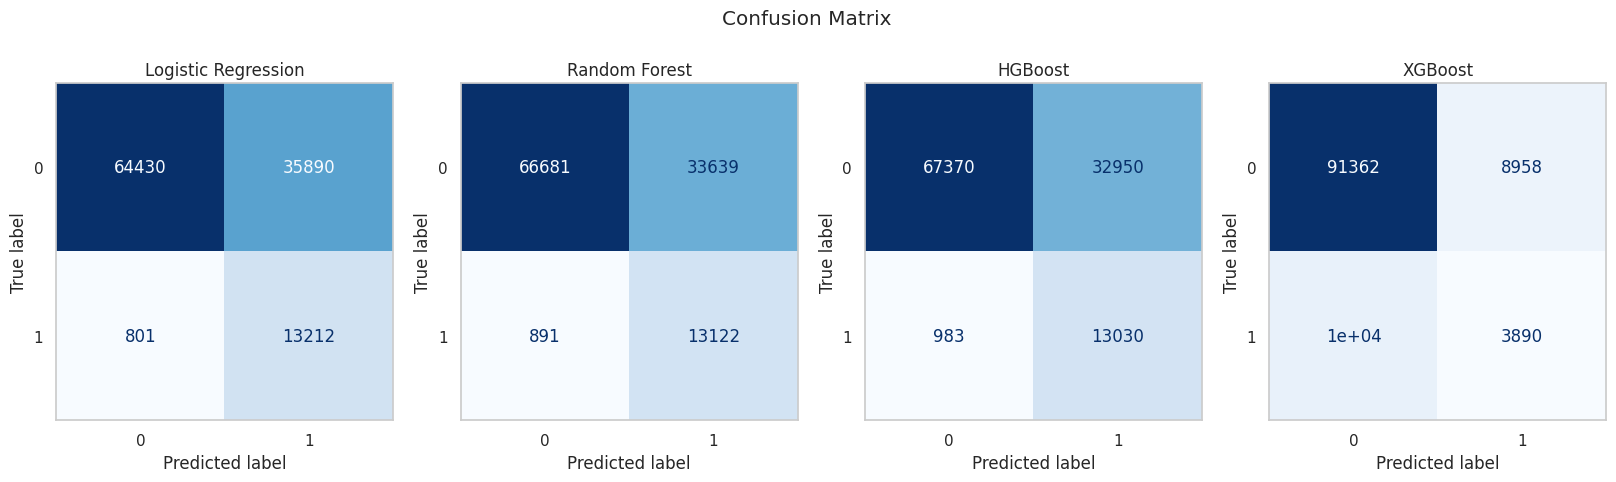

In [118]:
plot_confusion_matrix(models_list=models, y_true=y_valid)

#### Metrics @ K

In [86]:
def propensity_score(y_proba, n_samples):
    aux = pd.concat([X_valid, y_valid], axis=1)
    aux['score'] = y_proba[:, 1].tolist()
    aux = aux.sort_values('score', ascending=False)
    aux = aux[["id", 'response', 'score']].reset_index(drop=True)

    n = n_samples / X_valid.shape[0]      # percentage of data base represented by the number of calls

    print(f'K = {n_samples} represents {n * 100:.2f}% of the validation data base')

    # Precision Top K
    aux['precision_at_k'] = aux['response'].astype(int).cumsum() / (aux.index.values + 1)
    precision_at_k = aux.loc[n_samples, 'precision_at_k']
    print(f'Precision @ K: {precision_at_k * 100:.2f}%')

    # Recall Top K
    aux['recall_at_k'] = aux['response'].astype(int).cumsum() / aux['response'].astype(int).sum()
    recall_at_k = aux.loc[n_samples, 'recall_at_k']
    print(f'Recall @ K: {recall_at_k * 100:.2f}%')

    fig, ax = plt.subplots(1, 2, figsize=(14,5))

    # Gains curve --> Recall (gain) as a function of percentage of sample
    skplt.metrics.plot_cumulative_gain(y_probas=y_proba, y_true=y_valid, ax=ax[0])
    ax[0].vlines(x=n, ymin=0, ymax=recall_at_k, linestyles='dashed', colors='purple')
    ax[0].hlines(y=recall_at_k, xmin=0, xmax=n, linestyles='dashed', colors='purple')
    ax[0].hlines(y=n, xmin=0, xmax=n, linestyles='dashed', colors='purple')

    # Lift curvr --> Lift represents the percentage of customers interested in car insurance as a function of the percentage sample 
    skplt.metrics.plot_lift_curve(y_probas=y_proba, y_true=y_valid, ax=ax[1])
    ax[1].vlines(x=n, ymin=0, ymax=recall_at_k/n, linestyles='dashed', color='purple')
    ax[1].hlines(y=recall_at_k/n, xmin=0, xmax=n, linestyles='dashed', color='purple')
    ax[1].set_xlim(0.05, 1)
    ax[1].set_ylim(0.5, 3.5)

    return aux

K = 25000 represents 21.87% of the validation data base
Precision @ K: 33.53%
Recall @ K: 59.82%


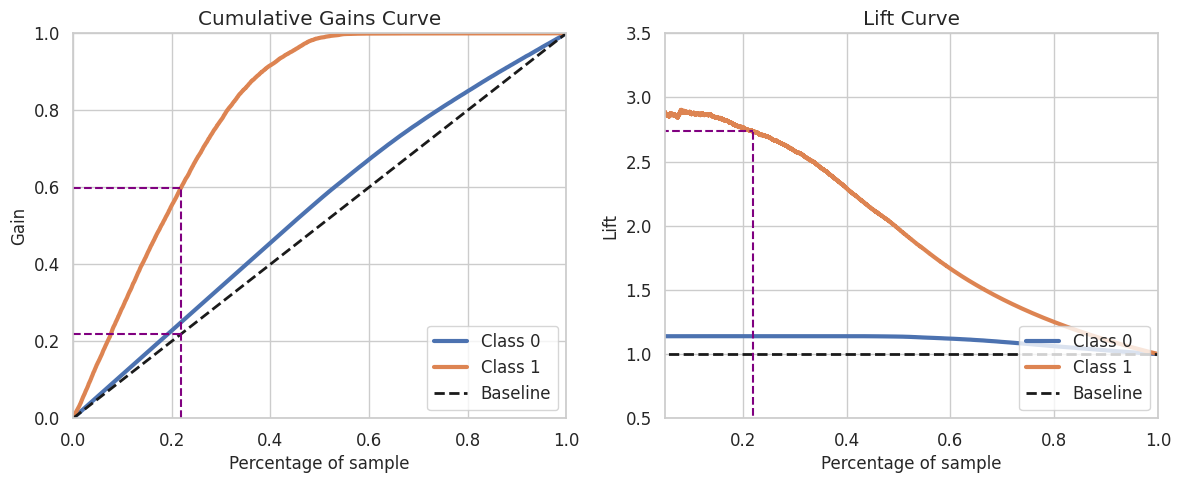

In [119]:
# Logreg
K = 25000
propensity_log_reg = propensity_score(y_proba=y_pred_proba_log_reg, n_samples=K)

K = 25000 represents 21.87% of the validation data base
Precision @ K: 34.63%
Recall @ K: 61.79%


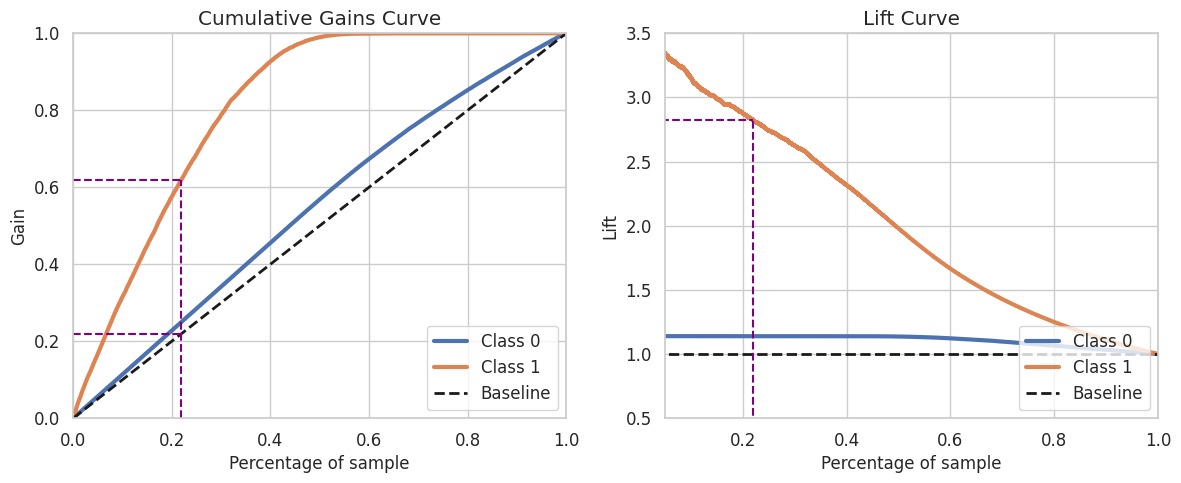

In [120]:
# Random Forest
K = 25000
propensity_rf = propensity_score(y_proba=y_pred_proba_rf, n_samples=K)

K = 25000 represents 21.87% of the validation data base
Precision @ K: 35.08%
Recall @ K: 62.59%


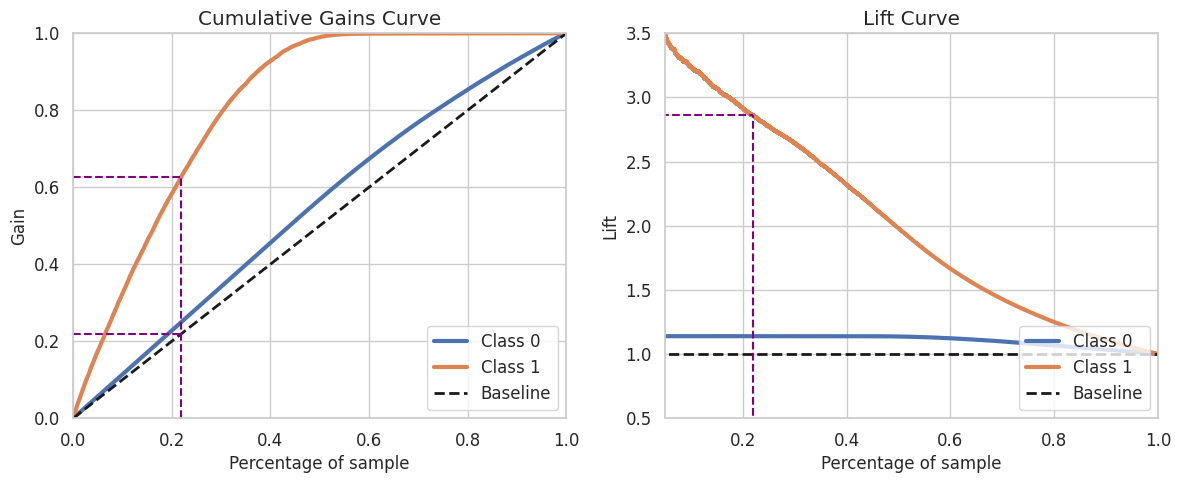

In [121]:
# HGBoost
K = 25000
propensity_hgb = propensity_score(y_proba=y_pred_proba_hgb, n_samples=K)

K = 25000 represents 21.87% of the validation data base
Precision @ K: 27.93%
Recall @ K: 49.84%


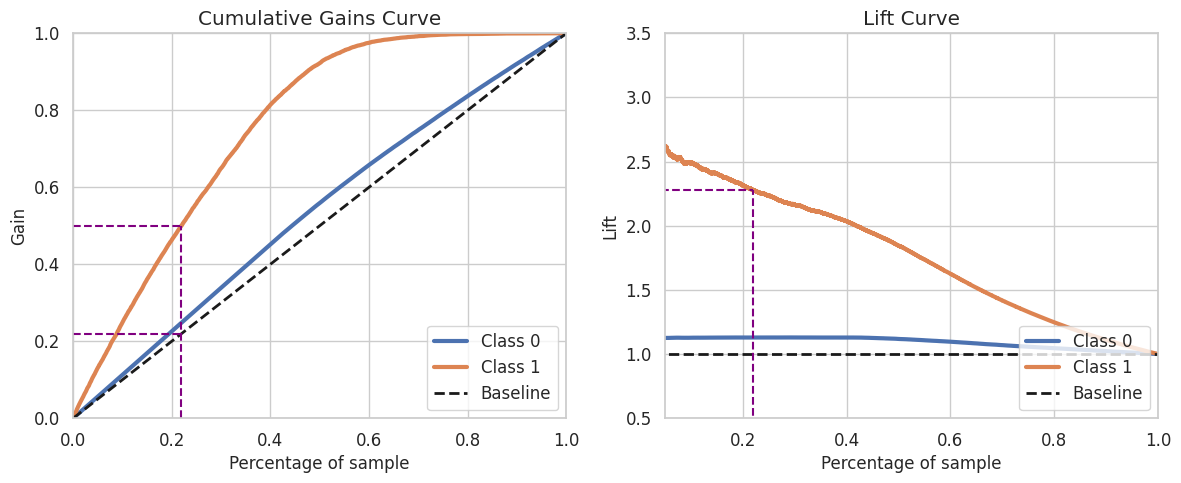

In [122]:
# XGBoost
K = 25000
propensity_xgb = propensity_score(y_proba=y_pred_proba_xgb, n_samples=K)

#### Baseline vs. ML Model

In [95]:
def baseline_vs_mlmodel(n_samples, aux):
    total_class_1 = y_valid.value_counts()[1]

    random_selection = df_valid[["id", "Response"]].sample(n=K)
    total_random = random_selection["Response"].value_counts()[1]

    total_ml_model = aux.iloc[:K, 0:2]["response"].value_counts()[1]

    avg_insurance = 1000.00     # hypothetical anual average cost of vehicle insurance in US$
    cost_per_contact = 1.00     # hypothetical cost per contact in US$

    random_cost = total_random * cost_per_contact
    ML_cost = total_ml_model * cost_per_contact

    random_revenue = avg_insurance * total_random
    ML_revenue = avg_insurance * total_ml_model

    n = n_samples / X_valid.shape[0]
    recall_at_k = aux.loc[n_samples, 'recall_at_k']

    summary = {'Recall': [n, recall_at_k],
               'Number of interests': [total_random, total_ml_model],
               'Contact per sale': [f'{K / total_random:.2f}', f'{K / total_ml_model:.2f}'],
               'Cost of contacts (US$)': [random_cost, ML_cost],
               'Revenue (US$)': [random_revenue, ML_revenue],
               "Profit (US$):": [random_revenue - random_cost, ML_revenue - ML_cost],
               'Gain (%)': ['-', f'{((ML_revenue-random_revenue)/random_revenue)*100:.2f}']}

    df_summary = pd.DataFrame(index=['Random', 'ML model'], data=summary)
    return df_summary

In [89]:
K=25000

In [123]:
# Logreg
baseline_vs_mlmodel(K, propensity_log_reg)

,Recall,Number of interests,Contact per sale,Cost of contacts (US$),Revenue (US$),Profit (US$):,Gain (%)
Random,0.21866,3056,8.18,3056.0,3056000.0,3052944.0,-
ML model,0.59823,8383,2.98,8383.0,8383000.0,8374617.0,174.31


In [124]:
# Random Forest
baseline_vs_mlmodel(K, propensity_rf)

,Recall,Number of interests,Contact per sale,Cost of contacts (US$),Revenue (US$),Profit (US$):,Gain (%)
Random,0.218660,3068,8.15,3068.0,3068000.0,3064932.0,-
ML model,0.617926,8659,2.89,8659.0,8659000.0,8650341.0,182.24


In [125]:
# HGBoost
baseline_vs_mlmodel(K, propensity_hgb)

,Recall,Number of interests,Contact per sale,Cost of contacts (US$),Revenue (US$),Profit (US$):,Gain (%)
Random,0.218660,3031,8.25,3031.0,3031000.0,3027969.0,-
ML model,0.625919,8771,2.85,8771.0,8771000.0,8762229.0,189.38


In [126]:
# XGBoost
baseline_vs_mlmodel(K, propensity_xgb)

,Recall,Number of interests,Contact per sale,Cost of contacts (US$),Revenue (US$),Profit (US$):,Gain (%)
Random,0.218660,3084,8.11,3084.0,3084000.0,3080916.0,-
ML model,0.498394,6984,3.58,6984.0,6984000.0,6977016.0,126.46


**Strategy**
- Reach the highest number of customers with potencial of purchasing insurance
- Recall must be increased in order to contact as many interested as possible

In [ ]:
models.keys()